# Deep Escape - a coding adventure in machine learning

To enjoy this adventure, run each cell one at a time and in order. Click on the cell you wish to run, the press shift-Enter (or click the play icon on the toolbar) to run a cell. The blue line on the left indicates which cell is currently selected to run.
When prompted to add code, you can press the plus (+) button on the above toolbar to add a new code cell. You will often copy and paste code that's been provided to you in previous cells. 

For a quick guide, and to see the basic adventure, don't modify the code. If you want to make changes, you might have to train a new model yourself, which can take at least an hour, if not more. But that's fine - this is meant to be used for experimentation!

![image](https://sagemaker-examples.readthedocs.io/en/latest/_images/successful_policy.gif)


## Level 1: The Awakening

You feel yourself being pulled into consiousness, like someone is talking to you and trying to get you out of bed, but you're still so tired. This voice... it just keeps talking and talking, but you can't make out the words. You try to open your eyes. You can't make them open. You can't even feel them, or your hands. You can't move! You start to panic, but finally, you hear the words clearly.

In [8]:
import IPython
# can eventually streamline these with event function calls
IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/youre_awake.mp3", autoplay=True)

*Oh, you're awake! That's good. Can your hear me? Yes. Ok, listen. I know you're confused, but I'm going to help you get out of here. But first you need to learn how to control a robot. You'll have to use a little bit of code.*

In [9]:
IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/this_is_your_console.mp3", autoplay=True)

*This is your console. There are many like it, but this one is yours.*

In [10]:
# Calibrating your settings
import sagemaker
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime

job_name_prefix = "deep-escape"
instance_type = "ml.c4.2xlarge"
job_duration_in_seconds = 3600

sagemaker_role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

s3_bucket = sagemaker_session.default_bucket()
s3_output_path = "s3://{}/".format(s3_bucket)
s3_prefix = job_name_prefix + "-sagemaker-" + strftime("%y%m%d-%H%M%S", gmtime())


print("sagemaker_role: {}".format(sagemaker_role))
print("s3_bucket: {}".format(s3_bucket))
print("s3_prefix: {}".format(s3_prefix))   

sagemaker_role: arn:aws:iam::688520471316:role/service-role/AmazonSageMaker-ExecutionRole-20210804T181687
s3_bucket: sagemaker-us-east-1-688520471316
s3_prefix: deep-escape-sagemaker-210806-001000


In [12]:
# Are you running this in a region that will work?
aws_region = sagemaker_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1"]:
    out = IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/config_failed.mp3", autoplay=True)
else:    
    out = IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/config_complete.mp3", autoplay=True)

out

In [13]:
IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/environment.mp3", autoplay=True)

*From here, you can run code that will use reinforcement learning to train a model. Your robot will use this model to move about in the world. The training uses an "agent", which is a virtual robot in this case. This agent is placed in an environment that has parameters. You define the rewards in a reward function by using the parameters from the environment.*

In [14]:
IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/uploaded_to_console.mp3", autoplay=True)

*I'm uploading it to your console now*

In [15]:
!pygmentize ./straight.py

def reward_function(params):
    '''
    Example of rewarding the agent to follow a center line
    '''
    
    # Read input parameters
    track_width = params['track_width']
    distance_from_center = params['distance_from_center']
    
    # Calculate 3 markers that are at varying distances away from the center line
    marker_1 = 0.1 * track_width
    marker_2 = 0.25 * track_width
    marker_3 = 0.5 * track_width
    
    # Give higher reward if the car is closer to center line and vice versa
    if distance_from_center <= marker_1:
        reward = 1.0
    elif distance_from_center <= marker_2:
        reward = 0.5
    elif distance_from_center <= marker_3:
        reward = 0.1
    else:
        reward = 1e-3  # likely crashed/ close to off track
    
    return float(reward)


### Rewards for the Robot

You see before you a bunch of Python code. How you can see it without seeing does't make much sense, but you're willing to play along with this mysterious voice. You're pretty decent at hacking on Python, so you notice the key points about the function being displayed.

It says it's an example for rewarding an agent to follow a center line. An agent? They must mean a robot! This must be how you train a model that a robot can use to drive around. Following a line is probably the easiest thing you can do.

There are two main inputs to this reward function:
* `track_width`
* `distance_from_center`

It goes on to provide different rewards based on a few scenarios. Three markers are created that are used like a bullseye around the center of the track. If the agent's position closest to the center by being within 10% of either side of the center the agent gets a reward of 1. If it's within 25%, it gets 0.5 as a reward. If it's within 50%, it gets .1. If it's not any of these, well, it must be off the track because 50% on either side is the whole track width!

[diagram]

Ok, so what do I do with this?

In [ ]:
IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/unlocking.mp3", autoplay=True)

*I'm unlocking some new input parameters for you.*

In [31]:
IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/unlocked_track_width.mp3", autoplay=True)

*Congratulations! You have unlocked: track_width*

In [32]:
IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/unlocked_distance_from_center.mp3", autoplay=True)

*Congratulations! You have unlocked: distance_from_center*



*TODO:* streamline the code below; there's way too much going on that I don't want to set manually

In [87]:
custom_hyperparameter = {
    "s3_bucket": s3_bucket,
    "s3_prefix": s3_prefix,
    "aws_region": aws_region,
    "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
    "reward_function_s3_source": "%s/straight.py" % s3_prefix,
    "batch_size": "64",
    "num_epochs": "10",
    "stack_size": "1",
    "lr": "0.0003",
    "exploration_type": "Categorical",
    "e_greedy_value": "1",
    "epsilon_steps": "10000",
    "beta_entropy": "0.01",
    "discount_factor": "0.999",
    "loss_type": "Huber",
    "num_episodes_between_training": "20",
    "max_sample_count": "0",
    "sampling_frequency": "1"
    #     ,"pretrained_s3_bucket": "sagemaker-us-east-1-259455987231"
    #     ,"pretrained_s3_prefix": "deepracer-notebook-sagemaker-200729-202318"
}

estimators_kwargs = {
    "entry_point": "base_training_worker.py",
    "source_dir": "src",
    "dependencies": ["common/"],
    "role": sagemaker_role,
    "train_instance_type": instance_type,
    "train_instance_count": 1,
    "output_path": s3_output_path,
    "base_job_name": job_name_prefix,
#    "metric_definitions": metric_definitions,
    "train_max_run": job_duration_in_seconds,
    "hyperparameters": custom_hyperparameter,
#    "subnets": deepracer_subnets,
#    "security_group_ids": deepracer_security_groups,
}

#custom_image_name = ""
#estimators_kwargs["image_uri"] = custom_image_name
#estimator = RLEstimator(**estimators_kwargs)
#estimator.fit(wait=False)
#job_name = estimator.latest_training_job.job_name
#print("Training job: %s" % job_name)

### Trial and Error
*TODO: If we could load the console in another tab in Studio, we could direct them to preview the job there!*

You watch as a Robomaker training job is run from your console. After a few moments a video player appears that shows a cartoon car and race track. The car - this must be the "agent" - just sits there while a message blinks "initializing". A graph appears next to it, showing the start of a few lines for "average reward" and "percent completion" for training and evaluation. The video begins to play. The car moves along the track and quickly swerves, crashing into the side of the track. The simulation appears to restart, with the car back in the middle of the track. It tries again. This time it makes a little further, then crashes into the right side of the track. This repeats over and over and over with the car turning wildly into the side after making a fairly decent run. After a while you notice that it isn't starting from the beginning. It starts from were it last crashed. Interesting. You can see its progress by the presence of a ghostly overlay showing the entire track with a little purple sphere representing the current position of the car-agent. 

In [16]:
# Would display a streaming video here, but it is blocked from some reason; player loads, but playback doesn't work
IPython.display.Video("https://aaron-1.s3.amazonaws.com/audio/first_tries.mp4")

In [6]:
IPython.display.Video("./first_tries.mp4")

Eventually, it makes it all of the way around the track. Time passes as the little agent goes through its trials. Every mistake is part of its training. Every success, a reward is granted.

You notice after several laps that the chart is starting to form some meaning. It has a low reward value and low completion value. Over time, you see the agent making fewer and fewer mistakes and staying on the track for longer. After an hour, the training session stops and you review the graph.

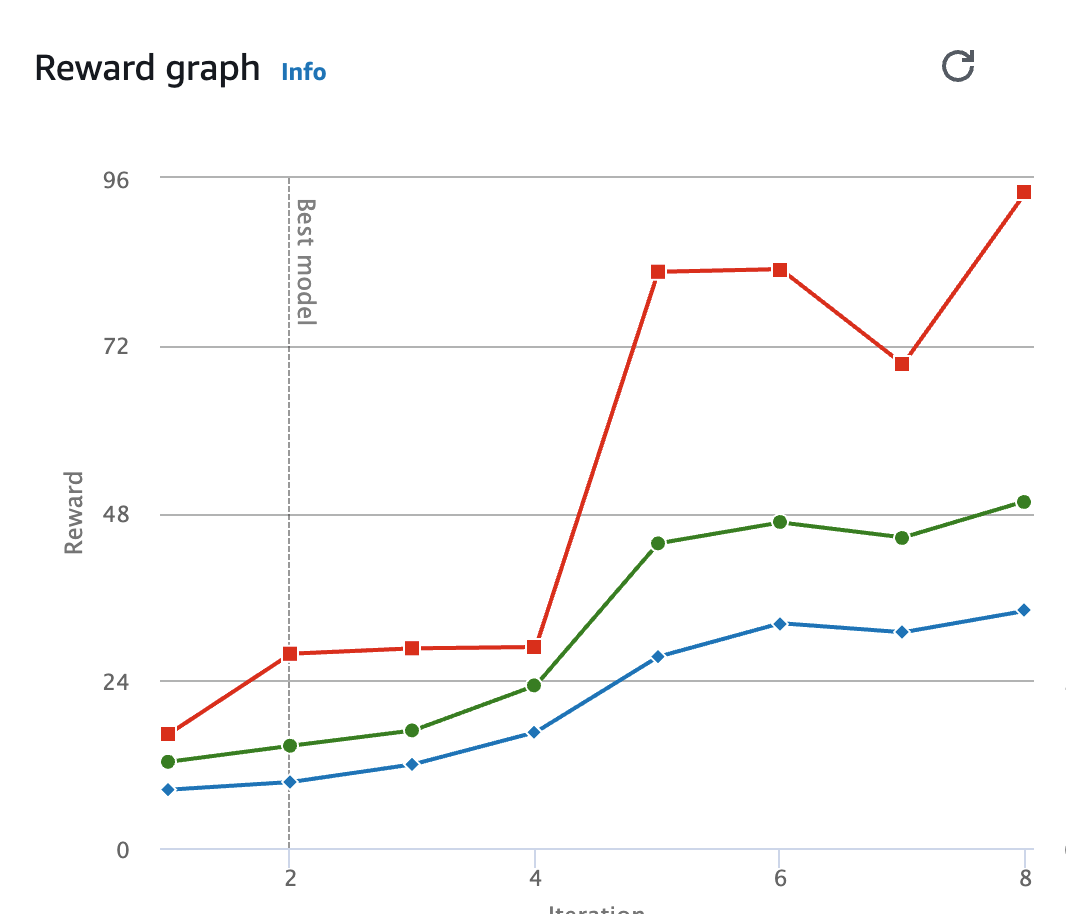

In [22]:
# TODO: Fix image so bottom isn't clipped
IPython.display.Image("https://aaron-1.s3.amazonaws.com/image/rl_training_graph.png", width=600)

### Deployment
{apply the model to move to next level; would be interesting to trap when there's a failure, and do a reset, so they get the full trial and error experience}

{display the skill tree, then unlock new skills!}

Unlocks: wheels (all_wheels_on_track)

In [34]:
IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/unlocked_wheels.mp3", autoplay=True)

*Congratulations! You have unlocked: all_wheels_on_track*

In [27]:
!pygmentize ./wheels_track_width.py

def reward_function(params):
    '''
    Example of rewarding the agent to stay inside the two borders of the track
    '''
    
    # Read input parameters
    all_wheels_on_track = params['all_wheels_on_track']
    distance_from_center = params['distance_from_center']
    track_width = params['track_width']
    
    # Give a very low reward by default
    reward = 1e-3

    # Give a high reward if no wheels go off the track and 
    # the car is somewhere in between the track borders 
    if all_wheels_on_track and (0.5*track_width - distance_from_center) >= 0.05:
        reward = 1.0

    # Always return a float value
    return reward


### How to use skills
{show how track width works; display the code for the input params for the new skills; they'll use these in the next level to pass the obstacle; skills can be easy-to-use functions that can be cobbled together and expand the action space for the player}


## Level 2: The walls are lava
{inside the vent, robot can't touch the walls or it'll get stuck (realize that the offtrack even mean both wheels went off, not just the outside ones, so might need to recast this so it is technically accurate... or not)}

Unlocks: steering (abs_steering)

In [35]:
IPython.display.Audio("https://aaron-1.s3.amazonaws.com/audio/unlocked_steering.mp3", autoplay=True)

*Congratulations! You have unlocked: abs_steering*

In [29]:
!pygmentize ./zigzag.py

def reward_function(params):
    '''
    Example of penalize steering, which helps mitigate zig-zag behaviors
    '''
    
    # Read input parameters
    distance_from_center = params['distance_from_center']
    track_width = params['track_width']
    abs_steering = abs(params['steering_angle']) # Only need the absolute steering angle

    # Calculate 3 marks that are farther and father away from the center line
    marker_1 = 0.1 * track_width
    marker_2 = 0.25 * track_width
    marker_3 = 0.5 * track_width

    # Give higher reward if the car is closer to center line and vice versa
    if distance_from_center <= marker_1:
        reward = 1.0
    elif distance_from_center <= marker_2:
        reward = 0.5
    elif distance_from_center <= marker_3:
        reward = 0.1
    else:
        reward = 1e-3  # likely crashed/ close to off track

    # Steering penality threshold, change the number based on your action space setting
    ABS_STEERING_THRESHOLD = 15 

    # Penalize reward i

## Level 3: Straight > zig zag
{fan is starting soon, so robot must make it in time and learn not to zigzag}

Unlocks: speed

## Level 4: Full speed ahead
{fan is on now and you noticed you are going faster; you need to adjust your speed so you don't crash at a turn in the vent.}

Unlocks: throttle, object distance, object location

## Level 5: I was blind, but now I can see
{You see a light at the end of the tunnel! There's and opening in the vent. You get to the end, but it's blocked by a vent door. It opens a little when you run into it. You decide to go back at hit it hard enough to open the vent door.}

Unlocks: crashed, track length

## Level 6: Charge!
{You recall how long it was from the turn to the vent opening. You return to the starting point, so that you can try to bash through the vent, but only enough to open it, not damage yourself.}

Unlocks: waypoints, progress

## Level 7: A dodgy affair
{Once out of the vent your see that you're in an office/lab where men and women in lab coats are wroking. You bide your time watching for patterns. You notice that when one leaves, the door remains open for 10 seconds. More than enough time for you to slip through!}

Unlocks: dodge

In [30]:
!pygmentize ./dodge.py

import math
def reward_function(params):
    '''
    Example of rewarding the agent to stay inside two borders
    and penalizing getting too close to the objects in front
    '''
    all_wheels_on_track = params['all_wheels_on_track']
    distance_from_center = params['distance_from_center']
    track_width = params['track_width']
    objects_location = params['objects_location']
    agent_x = params['x']
    agent_y = params['y']
    _, next_object_index = params['closest_objects']
    objects_left_of_center = params['objects_left_of_center']
    is_left_of_center = params['is_left_of_center']
    # Initialize reward with a small number but not zero
    # because zero means off-track or crashed
    reward = 1e-3
    # Reward if the agent stays inside the two borders of the track
    if all_wheels_on_track and (0.5 * track_width - distance_from_center) >= 0.05:
        reward_lane = 1.0
    else:
        reward_lane = 1e-3
    # Penalize if the agent is too close to the next object
  

## Level 8: Speak, or forever hold your peace
{You use Polly to find your voice.}

Unlocks: speech

## Level 9: Doppelganger
{You create a bot to take your place and chat when they check on you. (so you can escape)}

Unlocks: chatbot

## Level 10: Polyglot
{understand what a new character is saying to you}

Unlocks: linguist